# Class 2: Principal Component Analysis (PCA)

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 110
%precision 3
pd.set_option('display.precision', 3)
np.set_printoptions(suppress=True, precision=3)

## Motivating PCA: from 2 features to 1

**The central question:** Can we summarize information from multiple features using fewer features?

**Why reduce dimensions?**
- Combat curse of dimensionality: high dimensions make similarity less meaningful
- Visualization: easier to see patterns in 2D than in 9D
- Understanding: discover the "main stories" hidden in many variables
- Computation: fewer features = faster algorithms

Let's work with country-level economic data from the World Bank to assess the development of countries. First, we'll focus on two important indicators that form the **Phillips curve**: the empirical relationship between unemployment and inflation.

In [2]:
# Load the data
df = pd.read_csv('../data/economic_indicators/countries_wb_2020_2023.csv')

# EU countries & relevant features
wb_eu = df[df['is_EU'] == 1][['Unemployment_rate', 'Inflation_rate']]


### Recall: what is the first step?

In [3]:
# Know your data - always start by exploring it
wb_eu.describe()

# already nicely put together for you to save time

,Unemployment_rate,Inflation_rate
count,27.000,27.000
mean,5.752,7.131
std,2.255,3.293
min,2.579,3.305
25%,4.170,4.180
50%,5.589,6.299
75%,6.670,9.138
max,12.179,17.125


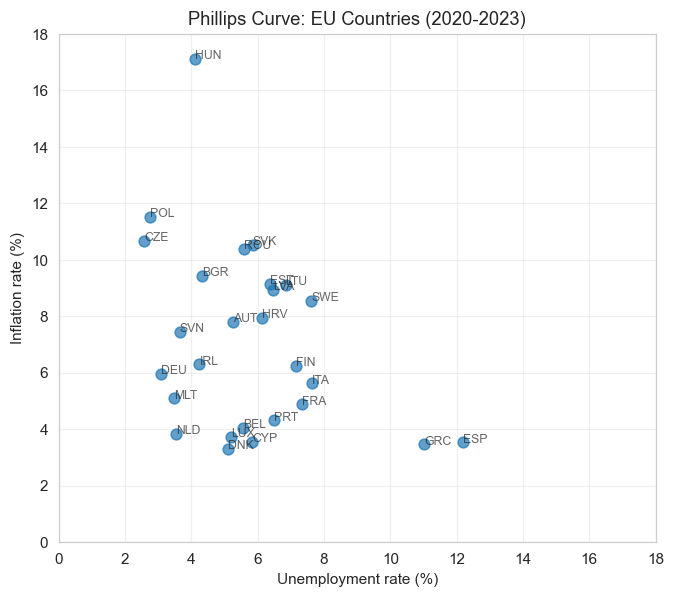

In [4]:
plt.figure(figsize=(7, 6))
plt.scatter(wb_eu['Unemployment_rate'], wb_eu['Inflation_rate'], alpha=0.7, s=50)
plt.xlabel('Unemployment rate (%)')
plt.ylabel('Inflation rate (%)')
plt.title('Phillips Curve: EU Countries (2020-2023)')
plt.grid(alpha=0.3)
plt.xlim(0, 18)
plt.ylim(0, 18)

# Create all text annotations
texts = []
for idx, country in enumerate(df[df['is_EU'] == 1]['Country']):
    texts.append(plt.text(
        wb_eu['Unemployment_rate'].iloc[idx], 
        wb_eu['Inflation_rate'].iloc[idx], 
        country, 
        fontsize=8, alpha=0.7
    ))

plt.show()

### Projection: The Key Idea

**The question:** If we must compress these two features into one, how should we do it?

**The answer:** Project the data onto a line. But which line?

**Intuition:** When we project points onto a line, we're "flattening" our 2D data into 1D. Different lines preserve different amounts of information:
- If projected points are **spread far apart**, we preserve more information (we can still distinguish countries)
- If projected points **cluster together**, we lose information (countries become indistinguishable)

**Measuring information:** We quantify "spread" using **variance**. Higher variance along the projection direction = more information preserved.

**PCA's goal:** Find the line (direction) that maximizes variance when we project onto it.

Let's visualize this by projecting our European countries data onto several different directions and comparing how much variance each preserves.

In [5]:
def plot_data_with_projection(direction_vector, data, ax=None):
    """Plot data points and their projections onto a given direction through the data center."""
    if ax is None:
        ax = plt.gca()
    
    direction = direction_vector / np.linalg.norm(direction_vector)  # normalize to unit vector
    
    # Get the data as array
    X_array = data.values
    
    # Calculate the center point (mean)
    center = X_array.mean(axis=0)
    
    # Center the data
    X_centered = X_array - center
    
    # Plot original data points
    ax.scatter(X_array[:, 0], X_array[:, 1], alpha=0.6, s=50, label='Original points', zorder=3)

    # Calculate projections onto the direction (for centered data)
    projections_1d = X_centered @ direction  # scalar projection for each point
    projections_centered = np.outer(projections_1d, direction)  # back to 2D coordinates (centered)
    projections = projections_centered + center  # shift back to original coordinate system

    # Plot projection points
    ax.scatter(projections[:, 0], projections[:, 1], color='darkred', alpha=0.6, s=50, 
               label='Projected points', zorder=3)

    # Draw lines between original points and their projections
    for i in range(len(X_array)):
        ax.plot([X_array[i, 0], projections[i, 0]], [X_array[i, 1], projections[i, 1]], 
                color='gray', alpha=0.3, linewidth=1, zorder=1)

    # Draw the projection direction as a line through the center point
    scale = 15
    ax.plot([center[0] - scale * direction[0], center[0] + scale * direction[0]], 
            [center[1] - scale * direction[1], center[1] + scale * direction[1]], 
            color='darkred', linewidth=2, alpha=0.7, label='Projection direction', zorder=2)

    ax.set_xlabel('Unemployment rate (%)')
    ax.set_ylabel('Inflation rate (%)')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(alpha=0.3)
    
    ax.set_xlim(0, 18)
    ax.set_ylim(0, 18)

    # Calculate and display variance preserved
    variance_preserved = np.var(projections_1d)
    ax.text(0.05, 0.95, f'Variance: {variance_preserved:.2f}', 
            transform=ax.transAxes, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

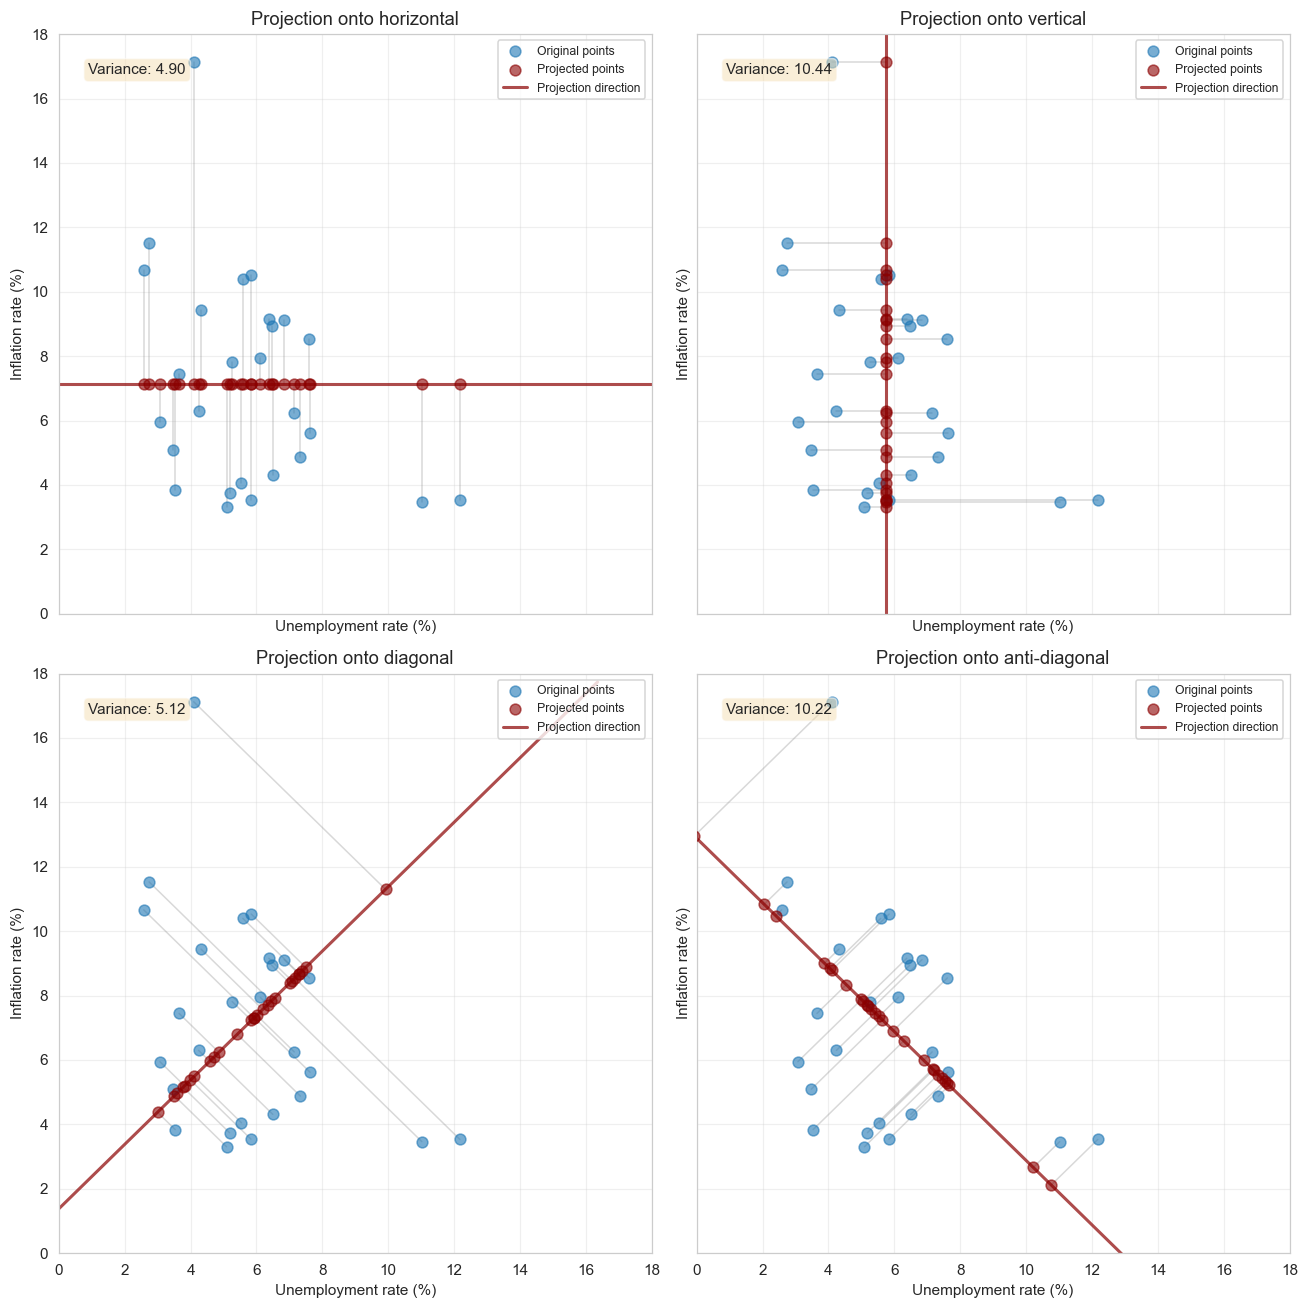

In [6]:
# Create a 2x2 grid of plots with different projection directions
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

# Try different projection directions
plot_data_with_projection([1, 0], wb_eu, ax=ax1)
ax1.set_title("Projection onto horizontal")

plot_data_with_projection([0, 1], wb_eu, ax=ax2)
ax2.set_title("Projection onto vertical")

plot_data_with_projection([1, 1], wb_eu, ax=ax3)
ax3.set_title("Projection onto diagonal")

plot_data_with_projection([-1, 1], wb_eu, ax=ax4)
ax4.set_title("Projection onto anti-diagonal")
plt.tight_layout()
plt.show()

**What do we observe?**

**Key insight:** Some directions capture more of the data's natural spread than others. The direction that maximizes variance is the **first principal component (PC1)**. Higher variance means that points are spread out more, allowing us to better distinguish them.

Note that higher variance also means lower projection error (the distance between the original blue points and their projected red counterparts).

For a nice illustration, check this answer on [Cross Validated](https://stats.stackexchange.com/a/140579).

**PCA's algorithm:**
1. Find the direction with maximum variance → **PC1**
2. Find the perpendicular direction with maximum remaining variance → **PC2**
3. Continue for higher dimensions...

### Applying PCA with sklearn

#### Technical detour: sklearn model syntax

Most sklearn models follow a consistent workflow:
1. **Define** the model object (with parameters)
2. **Fit** the model to data (learn from the data)
3. **Transform** new data using the fitted model

Some steps can be merged (e.g., `fit_transform()`) or reversed (e.g., `inverse_transform()`).

Let's see this in action with PCA.

In [7]:
# Apply PCA and calculate the principal components as X_pca
pca = PCA() #definition of the model
pca

PCA()

In [8]:
pca.components_ # no components yet, the model is just defined, not fitted yet

AttributeError: 'PCA' object has no attribute 'components_'

In [9]:
pca.fit(wb_eu)

PCA()

In [10]:
pca.components_

array([[-0.364,  0.932],
       [ 0.932,  0.364]])

Now we have the principal components! These are the directions PCA found. 
The `components_` attribute shows the **loadings**: how each original feature contributes to each principal component.

*Unlike many ML algorithms, PCA is deterministic: you'll get the same results every time. 
The only ambiguity is the **sign** of components, which can be flipped without changing the meaning.
This is why we did not have to set the seed for reproducibility.*

Now let's **transform** the data to get the coordinates in the new PC space.

In [11]:
# Transform the data using PCA
wb_eu_pca = pca.transform(wb_eu)

# Note: You can also use fit_transform() to fit and transform in one step:
# wb_eu_pca = pca.fit_transform(wb_eu)

#### Technical detour: DataFrame vs Array

The result is a numpy array (not a DataFrame), containing each country's coordinates in PC space.

In [ ]:
print("Type of the original data: ", type(wb_eu))
print("Type of the transformed data: ", type(wb_eu_pca))

### Visualizing the PCA transformation

**What PCA does geometrically:**
1. **Centers the data** at the origin (shifts the mean to 0, 0)
2. **Finds PC1**: the direction of maximum variance through the centered data
3. **Finds PC2**: perpendicular to PC1, capturing the maximum remaining variance
4. **Rotates the coordinate system**: aligns axes with these principal component directions

Let's visualize this transformation:

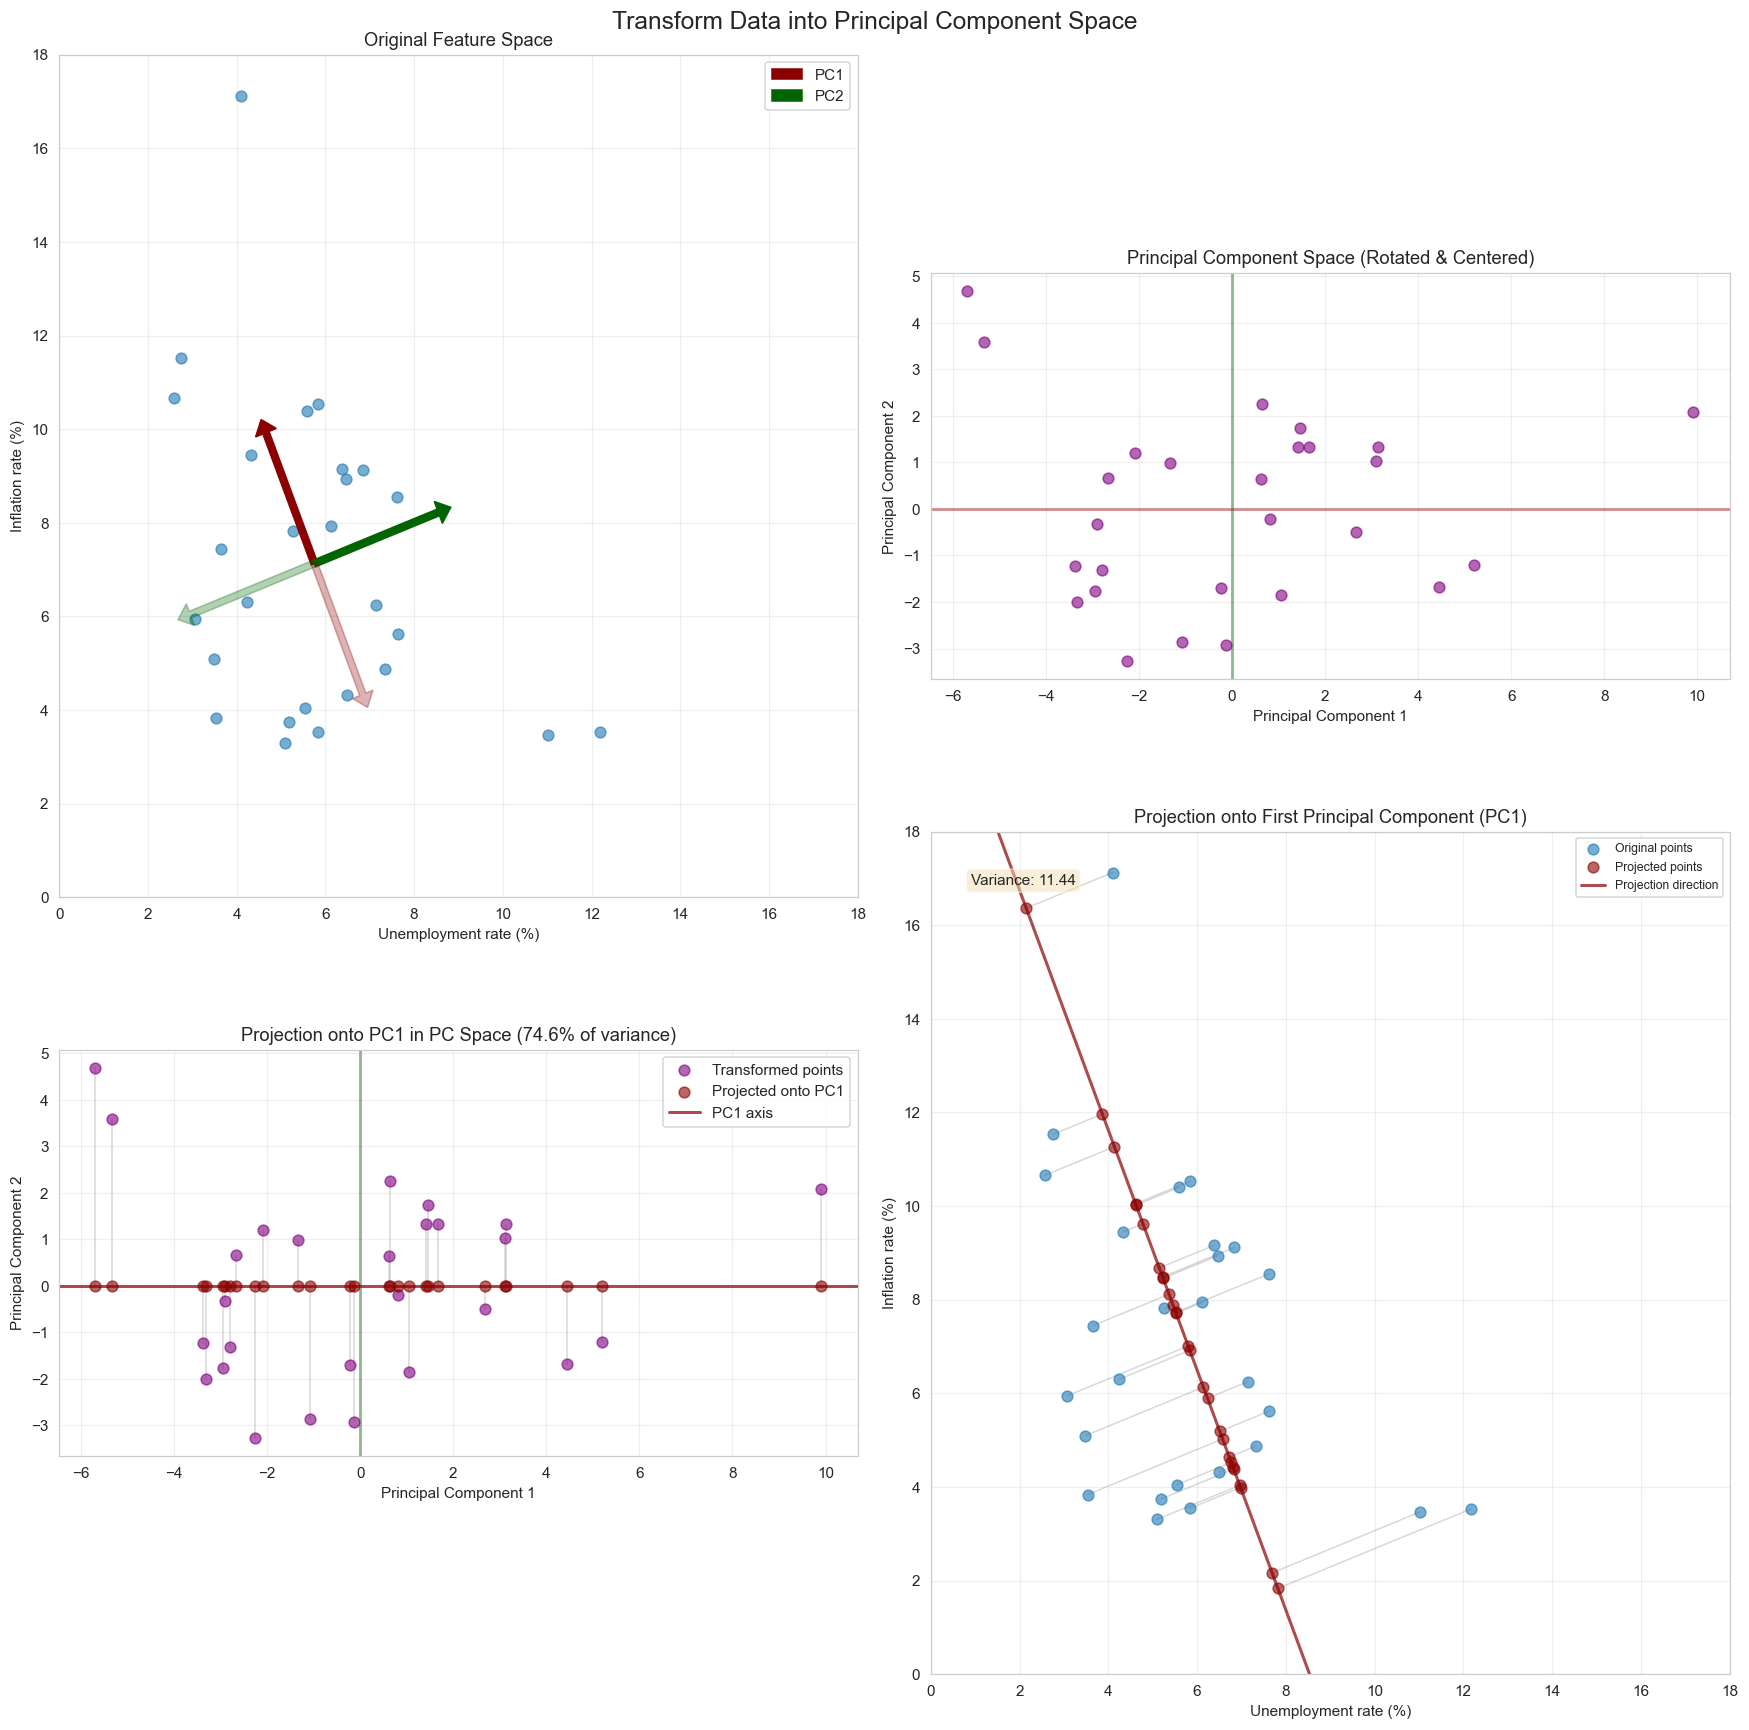

In [12]:
# Visualize the original data and the principal components
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))
    
fig.suptitle('Transform Data into Principal Component Space', fontsize=16)

# Subplot 1: Original data with PC directions
X_array = wb_eu.values
center = X_array.mean(axis=0)

ax1.scatter(wb_eu["Unemployment_rate"], wb_eu["Inflation_rate"], alpha=0.6, s=50)
ax1.set_xlabel('Unemployment rate (%)')
ax1.set_ylabel('Inflation rate (%)')
ax1.set_title('Original Feature Space')
ax1.grid(alpha=0.3)

# Draw PC directions from the center point (where PCA centers the data)
scale = 3  # scale the arrows for visibility
ax1.arrow(center[0], center[1], scale * pca.components_[0, 0], scale * pca.components_[0, 1], 
          color='darkred', width=0.15, head_width=0.5, head_length=0.3, label='PC1', zorder=5)
ax1.arrow(center[0], center[1], scale * pca.components_[1, 0], scale * pca.components_[1, 1], 
          color='darkgreen', width=0.15, head_width=0.5, head_length=0.3, label='PC2', zorder=5)
# Draw the opposite directions (without labels to avoid duplicate legend entries)
ax1.arrow(center[0], center[1], scale * -pca.components_[0, 0], scale * -pca.components_[0, 1], 
          color='darkred', width=0.15, head_width=0.5, head_length=0.3, zorder=5, alpha=0.3)
ax1.arrow(center[0], center[1], scale * -pca.components_[1, 0], scale * -pca.components_[1, 1], 
          color='darkgreen', width=0.15, head_width=0.5, head_length=0.3, zorder=5, alpha=0.3)

ax1.legend()
ax1.set_xlim(0, 18)
ax1.set_ylim(0, 18)

# Subplot 2: Transformed data in PC space
ax2.scatter(wb_eu_pca[:, 0], wb_eu_pca[:, 1], color='purple', alpha=0.6, s=50)
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_title('Principal Component Space (Rotated & Centered)')
ax2.grid(alpha=0.3)

# Draw PC axes as reference lines (without labels)
ax2.axhline(y=0, color='darkred', linestyle='-', alpha=0.4, linewidth=2)
ax2.axvline(x=0, color='darkgreen', linestyle='-', alpha=0.4, linewidth=2)

ax2.set_aspect('equal', adjustable='box')  # Make the aspect ratio equal to show true rotation

# Subplot 3: Projection onto PC1 in PC space
# Get PC1 direction
direction = pca.components_[0] / np.linalg.norm(pca.components_[0])

# Calculate center and projections
X_centered = X_array - center
projections_1d = X_centered @ direction

# Plot all points in PC space (from subplot 2)
ax3.scatter(wb_eu_pca[:, 0], wb_eu_pca[:, 1], color='purple', alpha=0.6, s=50, 
           label='Transformed points', zorder=3)

# Plot projected points (PC1 only, PC2 = 0)
ax3.scatter(projections_1d, np.zeros_like(projections_1d), color='darkred', alpha=0.6, s=50, 
           label='Projected onto PC1', zorder=3)

# Draw lines from transformed points to their projections on PC1 axis
for i in range(len(wb_eu_pca)):
    ax3.plot([wb_eu_pca[i, 0], projections_1d[i]], 
            [wb_eu_pca[i, 1], 0], 
            color='gray', alpha=0.3, linewidth=1, zorder=1)

# Draw PC1 axis (horizontal) and PC2 axis (vertical)
ax3.axhline(y=0, color='darkred', linestyle='-', alpha=0.7, linewidth=2, label='PC1 axis')
ax3.axvline(x=0, color='darkgreen', linestyle='-', alpha=0.4, linewidth=2)

ax3.set_xlabel('Principal Component 1')
ax3.set_ylabel('Principal Component 2')
ax3.set_title(f'Projection onto PC1 in PC Space ({pca.explained_variance_ratio_[0]*100:.1f}% of variance)')
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(alpha=0.3)
ax3.set_aspect('equal', adjustable='box')

# Subplot 4: Projection onto First Principal Component (PC1)
plot_data_with_projection(pca.components_[0], wb_eu, ax=ax4)
ax4.set_title('Projection onto First Principal Component (PC1)')

fig.tight_layout()

## Characteristics of PCA

Now that we've seen PCA in action, let's understand its key properties:
1. **Explained variance** - how much information each PC captures
2. **Loadings** - how original features combine to form PCs
3. **Orthogonality** - why PCs are perpendicular
4. **Reconstruction error** - the cost of dimensionality reduction

### 1. Explained Variance: quantifying information preserved

PCA finds directions in order of how much variance they explain. Let's see how much of the total variance each PC captures.

In [13]:
# Total variance in the original data (sum of variances of both features)
total_variance = np.var(wb_eu, axis=0).sum()
print(f'Total variance in original data: {total_variance:.2f}')
total_variance

Total variance in original data: 15.34


15.338

In [14]:
# Variance explained by each principal component (in absolute terms)
print('Variance explained by each PC:')
pca.explained_variance_

Variance explained by each PC:


array([11.876,  4.052])

In [15]:
# Proportion of total variance explained by each PC
print('Proportion of variance explained by each PC:')
pca.explained_variance_ratio_

Proportion of variance explained by each PC:


array([0.746, 0.254])

In [ ]:
print(f'PC1 explains {pca.explained_variance_ratio_[0] * 100:.1f}% of total variance')
print(f'PC2 explains {pca.explained_variance_ratio_[1] * 100:.1f}% of total variance')
print(f'Together: {pca.explained_variance_ratio_.sum() * 100:.1f}%')

### 2. Loadings: what PCs represent

**Loadings** tell us how each original feature contributes to each principal component.



#### Math detour

For each country, the new PC coordinates are computed as linear combinations of the original (centered) features:

$$\text{PC1}_i = w_{1,1} \cdot (\text{unemployment}_i - \text{avg}(\text{unemployment})) + w_{1,2} \cdot (\text{inflation}_i - \text{avg}(\text{inflation}))$$

$$\text{PC2}_i = w_{2,1} \cdot (\text{unemployment}_i - \text{avg}(\text{unemployment})) + w_{2,2} \cdot (\text{inflation}_i - \text{avg}({\text{inflation}}))$$

where:
- $w_{j,k}$ are the loadings from `pca.components_` (row $j$, column $k$)
- The centered features are the deviations from their means

In matrix form: $\mathbf{Z} = (\mathbf{X} - \bar{\mathbf{X}}) \mathbf{W}^T$, where $\mathbf{W}$ is the matrix of principal component directions (loadings).

In [16]:
# Display loadings
print("Loadings (how original features contribute to PCs):\n")
loadings_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=['Unemployment_rate', 'Inflation_rate']
)
loadings_df

Loadings (how original features contribute to PCs):



,PC1,PC2
Unemployment_rate,-0.364,0.932
Inflation_rate,0.932,0.364


**Interpretation:**
- **PC1** contrasts the features (negative loading on unemployment, positive on inflation) → it represents the **trade-off** between unemployment and inflation. Countries with high PC1 scores have high inflation and low unemployment.
- **PC2** has similar (positive) loadings on both features → it captures "overall economic stress" (high unemployment AND high inflation together)

**Key property:** Loadings are the coordinates of the principal component directions. They form unit vectors (length = 1), which you can verify: $\sqrt{\text{loading}_1^2 + \text{loading}_2^2} = 1$

#### Manual calculation example

Let's verify how to compute PC coordinates from loadings for a specific country (Austria):

In [ ]:
# Step 1: Get the original values for the first countr (Austria)
austria_data = wb_eu.iloc[0]
print("Austria's original features:")
print(austria_data)
print()

# Step 2: Calculate the mean of each feature (what PCA uses for centering)
feature_means = wb_eu.mean()
print("Feature means (used for centering):")
print(feature_means)
print()

# Step 3: Calculate the PC1 and PC2 values manually using the PCA components and the centered data
pc1_manual = (pca.components_[0, 0] * (austria_data['Unemployment_rate'] - feature_means['Unemployment_rate']) + 
              pca.components_[0, 1] * (austria_data['Inflation_rate'] - feature_means['Inflation_rate']))

pc2_manual = (pca.components_[1, 0] * (austria_data['Unemployment_rate'] - feature_means['Unemployment_rate']) + 
              pca.components_[1, 1] * (austria_data['Inflation_rate'] - feature_means['Inflation_rate']))
print(f"Manual calculation:")
print(f"PC1 = {pca.components_[0, 0]:.3f} × ({austria_data['Unemployment_rate']:.3f} - {feature_means['Unemployment_rate']:.3f}) + {pca.components_[0, 1]:.3f} × ({austria_data['Inflation_rate']:.3f} - {feature_means['Inflation_rate']:.3f}) = {pc1_manual:.3f}")
print(f"PC2 = {pca.components_[1, 0]:.3f} × ({austria_data['Unemployment_rate']:.3f} - {feature_means['Unemployment_rate']:.3f}) + {pca.components_[1, 1]:.3f} × ({austria_data['Inflation_rate']:.3f} - {feature_means['Inflation_rate']:.3f}) = {pc2_manual:.3f}")
print()

# Step 4: Compare with sklearn's transform
print(f"sklearn's transform result for Austria:")
print(f"PC1 = {wb_eu_pca[0, 0]:.3f}")
print(f"PC2 = {wb_eu_pca[0, 1]:.3f}")
print()
print("✓ They match!")

### 3. Orthogonality: why PCs are perpendicular

**Observation:** In our visualizations, PC1 and PC2 are always perpendicular (orthogonal). This isn't a coincidence—it's by design.

**Why orthogonality?** PCA's sequential construction ensures it:

1. **PC1** finds the direction that maximizes variance (no constraints)
2. **PC2** finds the direction that maximizes variance **among all directions perpendicular to PC1**
3. **PC3** maximizes variance perpendicular to both PC1 and PC2, and so on...

This sequential process has a beautiful consequence: each PC captures **independent** information (orthogonal = uncorrelated). You can verify this mathematically:

In [ ]:
# Verify orthogonality: dot product of PC1 and PC2 directions should be zero
dot_product = pca.components_[0] @ pca.components_[1]
print(f'Dot product of PC1 and PC2: {dot_product:.10f}')
print('(Should be essentially zero, confirming orthogonality)')

# Also verify: correlation between PC scores should be zero
correlation = np.corrcoef(wb_eu_pca[:, 0], wb_eu_pca[:, 1])[0, 1]
print(f'\nCorrelation between PC1 and PC2 scores: {correlation:.10f}')
print('(Zero correlation = independent dimensions)')

#### Math detour: Why are PCs orthogonal?

The orthogonality of principal components comes from the **eigendecomposition of the covariance matrix**. 

**The key mathematical fact:** When we compute PCA, we're finding the eigenvectors of the data's covariance matrix. Since covariance matrices are symmetric, their eigenvectors are guaranteed to be orthogonal (perpendicular) to each other.

**The intuition:** 
- The covariance matrix captures how features vary together
- Its eigenvectors point in the directions of maximum variance
- The eigenvalues tell us how much variance is in each direction
- PCA sorts these by eigenvalue (largest first) to get PC1, PC2, PC3, ...

For an excellent intuitive explanation of how "maximizing variance" is equivalent to "finding eigenvectors of the covariance matrix," see [this answer on Cross Validated](https://stats.stackexchange.com/a/219344).

### 4. Reconstruction Error: the cost of dimensionality reduction

**The trade-off:** If we use only PC1 (reducing from 2D to 1D), we lose some information. How much?

**Reconstruction:** We can "reverse" PCA to go back from PC space to the original feature space. This reconstructed data won't be perfect: the difference is the **reconstruction error**.

**Key relationship:** 
- Variance explained by PCs = Information preserved
- Reconstruction error = Information lost
- They sum to 100% of the original variance

Let's reconstruct our data using only PC1 and measure the error.

In [17]:
# Fit PCA with only 1 component
pca1 = PCA(n_components=1)
feature_1d = pca1.fit_transform(wb_eu)
print(f'Reduced data shape: {feature_1d.shape} -- from {wb_eu.shape}')
feature_1d.shape

Reduced data shape: (27, 1) -- from (27, 2)


(27, 1)

In [18]:
# Reconstruct back to 2D using inverse_transform
reconstructed_data = pca1.inverse_transform(feature_1d)
print(f'Reconstructed data shape: {reconstructed_data.shape}')
reconstructed_data.shape

Reconstructed data shape: (27, 2)


(27, 2)

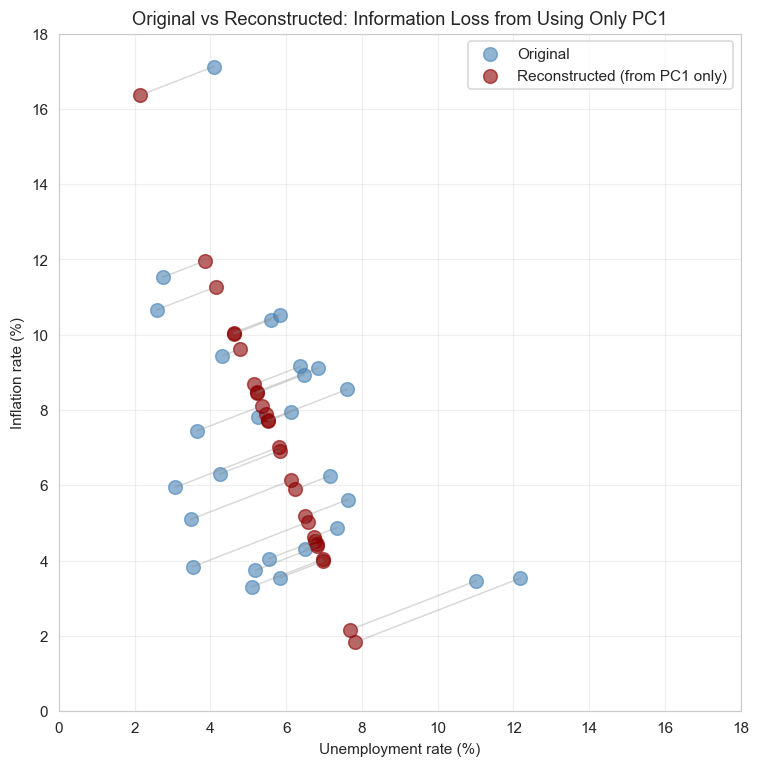

In [19]:
# Visualize original vs reconstructed data
plt.figure(figsize=(8, 8))

plt.scatter(wb_eu["Unemployment_rate"], wb_eu["Inflation_rate"], 
           alpha=0.6, s=80, label="Original", color='steelblue')
plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], 
           alpha=0.6, s=80, color="darkred", label="Reconstructed (from PC1 only)")

# Draw lines showing reconstruction error for each point
for i in range(len(wb_eu)):
    plt.plot([wb_eu["Unemployment_rate"].iloc[i], reconstructed_data[i, 0]], 
            [wb_eu["Inflation_rate"].iloc[i], reconstructed_data[i, 1]], 
            color='gray', alpha=0.3, linewidth=1)

plt.xlabel("Unemployment rate (%)")
plt.ylabel("Inflation rate (%)")
plt.title("Original vs Reconstructed: Information Loss from Using Only PC1")
plt.legend()
plt.xlim(0, 18)
plt.ylim(0, 18)
plt.grid(alpha=0.3)

plt.show()

In [20]:
# Calculate reconstruction error (mean squared distance between original and reconstructed)
def calculateReconstructionError(X, X_reconstructed):
    """Calculate average squared distance = variance not explained"""
    return np.mean(np.sum(np.square(X.values - X_reconstructed), axis=1))

reconstruction_error = calculateReconstructionError(wb_eu, reconstructed_data)
print(f'Reconstruction error: {reconstruction_error:.2f}')
reconstruction_error

Reconstruction error: 3.90


3.902

In [21]:
# Verify the relationship: explained variance + reconstruction error = total variance
relative_error = reconstruction_error / total_variance
print(f'Relative reconstruction error: {relative_error * 100:.1f}%')
print(f'Variance explained by PC1: {pca1.explained_variance_ratio_[0] * 100:.1f}%')
print(f'Sum: {(relative_error + pca1.explained_variance_ratio_[0]) * 100:.1f}%')
print('\n✓ They sum to 100%: reconstruction error measures what we lost!')

Relative reconstruction error: 25.4%
Variance explained by PC1: 74.6%
Sum: 100.0%

✓ They sum to 100%: reconstruction error measures what we lost!


### Connection to OLS regression

You've seen OLS (Ordinary Least Squares) regression before. How does it relate to PCA? Both fit lines to data, but they minimize different things!

**Key difference:**
- **OLS:** Minimizes **vertical** distances (residuals in Y) -- assumes X is the predictor and Y is the outcome
- **PCA:** Minimizes **perpendicular** distances to the line -- treats both variables symmetrically

**Why the difference matters:**
- OLS: "Predict Y from X" (asymmetric relationship)
- PCA: "Find the main direction of variation" (symmetric—no predictor/outcome distinction)

Let's visualize this difference.

In [22]:
# Fit OLS: predict Inflation from Unemployment
from sklearn.linear_model import LinearRegression
ols = LinearRegression().fit(wb_eu[["Unemployment_rate"]], wb_eu["Inflation_rate"])
print(f'OLS: Inflation = {ols.intercept_:.2f} + {ols.coef_[0]:.2f} × Unemployment')

OLS: Inflation = 10.13 + -0.52 × Unemployment


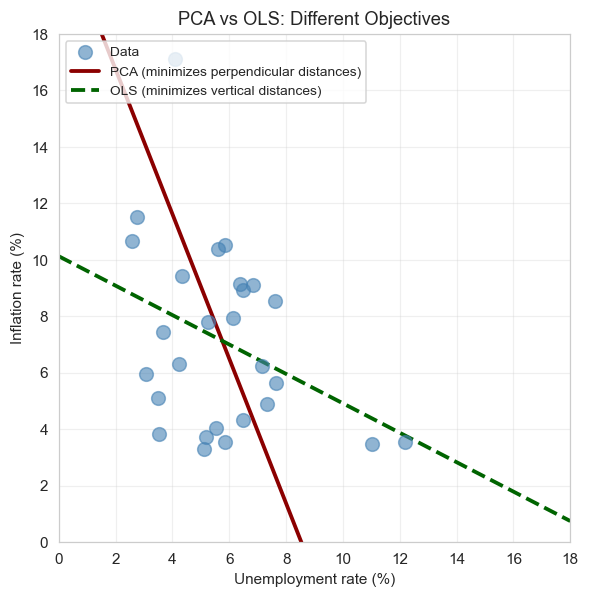

In [24]:
# Compare PCA vs OLS visually
plt.figure(figsize=(6, 6))

# Original data points
plt.scatter(wb_eu["Unemployment_rate"], wb_eu["Inflation_rate"], 
           alpha=0.6, s=80, label="Data", color='steelblue', zorder=3)

# PCA line (PC1 through the center of data)
center = wb_eu.values.mean(axis=0)
x_line = np.array([0, 18])
y_pca = center[1] + (pca.components_[0][1] / pca.components_[0][0]) * (x_line - center[0])
plt.plot(x_line, y_pca, color="darkred", linewidth=2.5, label="PCA (minimizes perpendicular distances)", zorder=2)

# OLS line
y_ols = ols.intercept_ + ols.coef_[0] * x_line
plt.plot(x_line, y_ols, '--', color="darkgreen", linewidth=2.5, 
        label="OLS (minimizes vertical distances)", zorder=2)

plt.xlabel("Unemployment rate (%)")
plt.ylabel("Inflation rate (%)")
plt.title("PCA vs OLS: Different Objectives")
plt.legend(loc='upper left', fontsize=9)
plt.xlim(0, 18)
plt.ylim(0, 18)
plt.grid(alpha=0.3)

plt.show()

**What we see:**
- The lines are similar but not identical
- PCA (red) treats both axes equally—it finds the "main direction" of the data cloud
- OLS (green) assumes unemployment predicts inflation—it minimizes prediction errors in the Y direction

**When to use which:**
- Use **OLS** when you have a clear predictor → outcome relationship
- Use **PCA** when you want to understand the overall structure or reduce dimensions without assuming causality

---

### Summary: PCA Fundamentals

**What we've learned so far:**

1. **Motivation:** PCA reduces dimensions by projecting data onto directions that maximize variance
2. **Mechanics:** Find PC1 (max variance), then PC2 (max remaining variance, perpendicular to PC1)
3. **Loadings:** Show how original features combine to form PCs
4. **Orthogonality:** PCs are perpendicular by construction (from sequential variance maximization)
5. **Reconstruction error:** Measures information lost when using fewer PCs
6. **Connection to OLS:** PCA minimizes perpendicular distances (symmetric), OLS minimizes vertical distances (asymmetric)

**Next step:** Apply these concepts to a real dataset with many features. We'll discover a critical issue that requires **standardization** before PCA can work properly!

## Full PCA: Multiple economic indicators, countries from all over the world

Now let's apply PCA to a richer dataset with **9 economic indicators** from countries worldwide. This will reveal both the power of PCA and a critical pitfall we must avoid.

**The indicators:**
- GDP per capita, GDP growth, Unemployment rate, Inflation rate
- Trade (% of GDP), Foreign direct investment, Government debt
- Life expectancy, Population growth

Let's see what happens when we apply PCA directly...


In [25]:
# Load and prepare the data
df = pd.read_csv('../data/economic_indicators/countries_wb_2020_2023.csv')

# Extract only the economic indicator features (drop categorical variables)
wb_features = df.drop(columns=['Country', 'Income_Level','Region','Region_Broad',
                               'is_BRICS','is_EU','is_G20','is_G7','is_OECD'])

print(f'Dataset shape: {wb_features.shape}')
print(f'Features: {list(wb_features.columns)}')
wb_features.describe()

Dataset shape: (70, 10)
Features: ['GDP_per_capita', 'Inflation_rate', 'Unemployment_rate', 'Trade_percent_GDP', 'Health_spending_pct_GDP', 'Life_expectancy', 'Internet_users_pct', 'RD_spending_pct_GDP', 'FDI_pct_GDP', 'School_enrollment_secondary_pct']


,GDP_per_capita,Inflation_rate,Unemployment_rate,Trade_percent_GDP,Health_spending_pct_GDP,Life_expectancy,Internet_users_pct,RD_spending_pct_GDP,FDI_pct_GDP,School_enrollment_secondary_pct
count,70.000,70.000,70.000,70.000,70.000,70.000,70.000,70.000,70.000,70.000
mean,33583.839,9.568,5.630,102.204,7.681,78.592,86.515,1.408,1.806,102.832
std,29236.896,16.633,4.039,67.127,2.751,4.549,13.900,1.241,17.250,17.699
min,1360.324,0.525,0.130,25.290,2.520,63.646,27.376,0.059,-63.155,42.291
25%,8807.150,3.849,3.545,55.124,5.693,75.941,83.469,0.481,0.595,95.335
50%,23979.292,5.908,4.997,82.890,7.975,78.620,89.382,1.006,1.962,102.967
75%,51488.908,9.073,6.689,131.326,9.688,82.390,95.314,1.937,3.880,108.428
max,133230.619,133.489,32.098,402.567,16.694,84.056,100.000,6.019,111.222,142.960


In [26]:
# Apply PCA
pca_full = PCA().fit(wb_features)

print('Variance explained by each PC:')
print(pca_full.explained_variance_ratio_)

Variance explained by each PC:
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


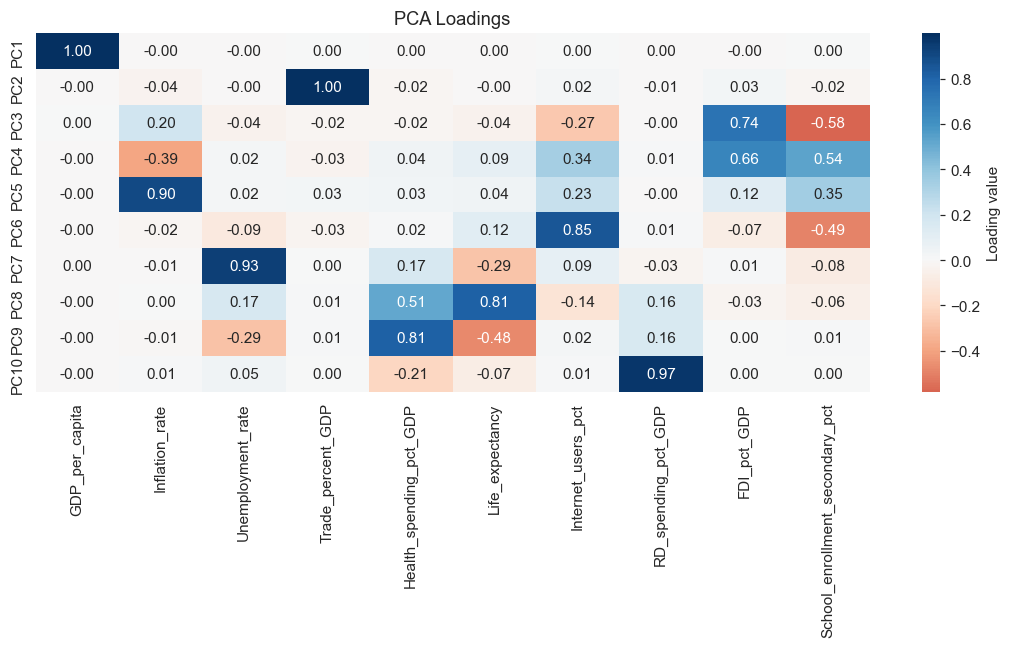

In [29]:
# Visualize the loadings to see what went wrong
def visualize_pca_loadings(pca, data, title='PCA Components Loadings'):
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        pca.components_, 
        cmap='RdBu', center=0, annot=True, fmt='.2f', 
        xticklabels=data.columns, 
        yticklabels=[f"PC{i+1}" for i in range(pca.n_components_)],
        cbar_kws={'label': 'Loading value'}
    )
    plt.title(title)
    plt.tight_layout()

visualize_pca_loadings(pca_full, wb_features, 'PCA Loadings')
plt.show()

**Problem identified!** 

PC1 has a loading of ~1.00 on GDP_per_capita and ~0.00 on everything else. It's essentially just GDP_per_capita renamed! Why did this happen?

Let's investigate the variance of each feature:

Variance of each feature:

GDP_per_capita                     8.426e+08
Trade_percent_GDP                  4.442e+03
School_enrollment_secondary_pct    3.088e+02
FDI_pct_GDP                        2.933e+02
Inflation_rate                     2.727e+02
Internet_users_pct                 1.904e+02
Life_expectancy                    2.040e+01
Unemployment_rate                  1.608e+01
Health_spending_pct_GDP            7.458e+00
RD_spending_pct_GDP                1.518e+00
dtype: float64

GDP_per_capita variance is 189701x larger than the next!


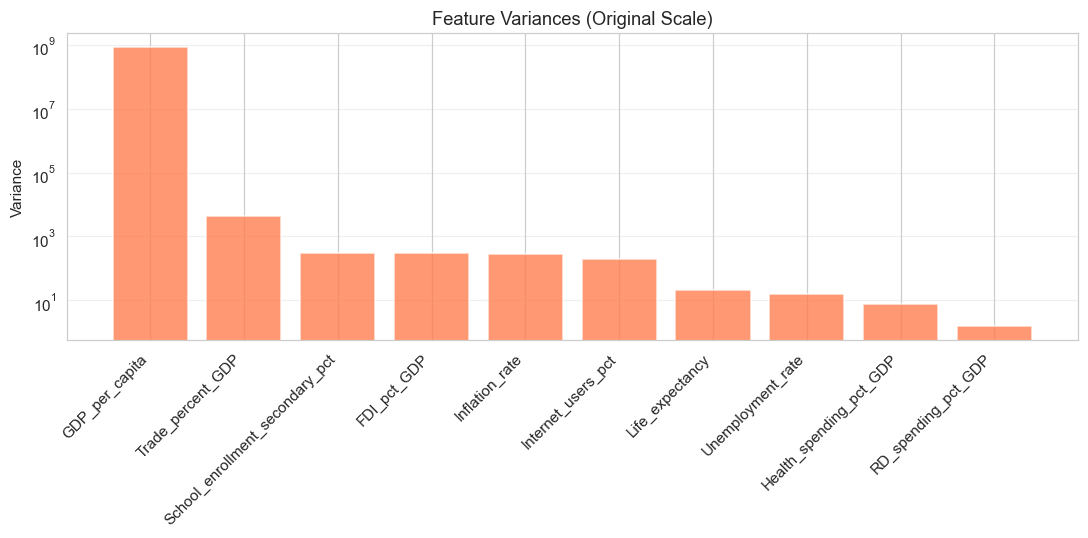

In [30]:
# Compare variances of each feature
feature_variances = np.var(wb_features, axis=0).sort_values(ascending=False)
print('Variance of each feature:\n')
print(feature_variances)
print(f'\nGDP_per_capita variance is {feature_variances.iloc[0] / feature_variances.iloc[1]:.0f}x larger than the next!')

# Visualize the scale difference
plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_variances)), feature_variances.values, color='coral', alpha=0.8)
plt.xticks(range(len(feature_variances)), feature_variances.index, rotation=45, ha='right')
plt.ylabel('Variance')
plt.title('Feature Variances (Original Scale)')
plt.yscale('log')  # Log scale to see all bars
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**The root cause:** PCA finds directions of maximum variance. GDP_per_capita has vastly higher variance (because it's measured in dollars, ranging from ~500 to ~100,000) than percentage-based indicators (ranging from 0 to ~20).

**Result:** PCA just picks GDP_per_capita because it has the most variance—not because it's the most important!

**The solution: Standardization**

Before applying PCA, we must **standardize** features to have:
- Mean = 0 (centering)
- Standard deviation = 1 (scaling)

This puts all features on equal footing so PCA discovers true patterns, not just scale artifacts.

Let's apply PCA correctly with standardization:

In [31]:
# Standardize the features using StandardScaler
scaler = StandardScaler()
scaler.set_output(transform="pandas")  # Keep output as DataFrame
scaled_wb = scaler.fit_transform(wb_features)

# Verify standardization worked
print('After standardization:')
print(f'Means (should be ~0): {np.mean(scaled_wb, axis=0).values}')
print(f'Variances (should be 1.0): {np.var(scaled_wb, axis=0).values}')

After standardization:
Means (should be ~0): [ 0. -0.  0.  0.  0.  0.  0.  0.  0.  0.]
Variances (should be 1.0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [32]:
# Apply PCA on standardized data
scaled_pca = PCA().fit(scaled_wb)
print('Variance explained by each PC (WITH scaling):')
print(scaled_pca.explained_variance_ratio_)

Variance explained by each PC (WITH scaling):
[0.388 0.147 0.106 0.101 0.091 0.06  0.034 0.031 0.024 0.02 ]


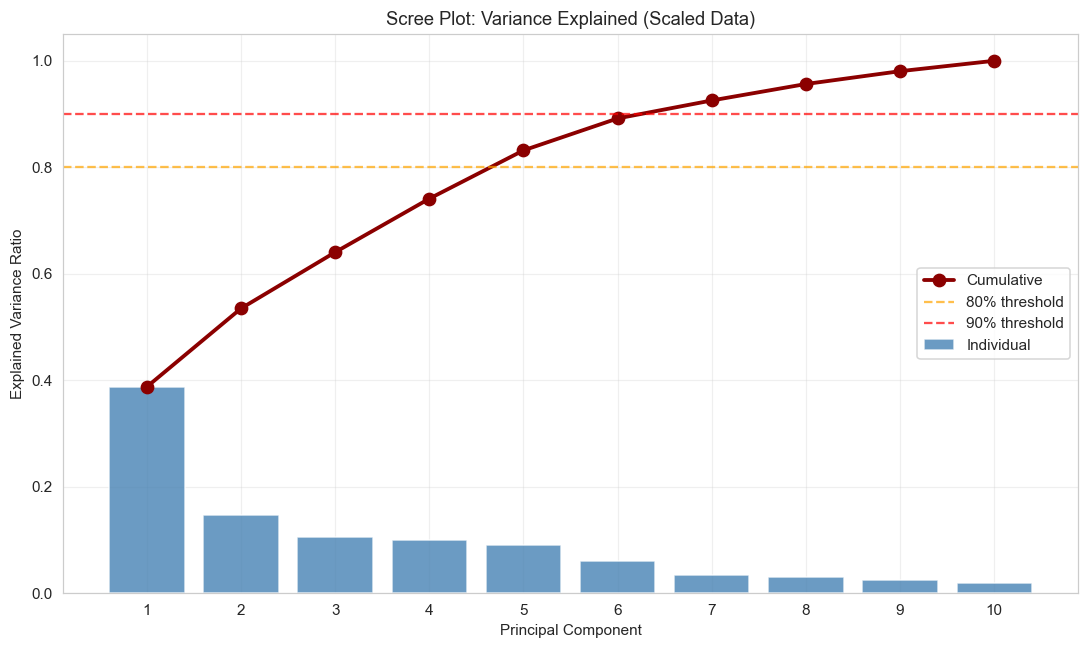

In [33]:
# Visualize explained variance (so called scree plot)
def visualize_explained_variance(explained_variance, title='Explained Variance by Principal Component'):
    plt.figure(figsize=(10, 6))
    
    # Bar chart for individual variance
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, 
           color='steelblue', alpha=0.8, label='Individual')
    
    # Line plot for cumulative variance
    cumulative = np.cumsum(explained_variance)
    plt.plot(range(1, len(explained_variance) + 1), cumulative, 
            color="darkred", marker="o", linewidth=2.5, markersize=8, label='Cumulative')
    
    # Reference lines for 80% and 90%
    plt.axhline(0.8, linestyle='--', color='orange', alpha=0.7, linewidth=1.5, label='80% threshold')
    plt.axhline(0.9, linestyle='--', color='red', alpha=0.7, linewidth=1.5, label='90% threshold')

    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title(title)
    plt.xticks(range(1, len(explained_variance) + 1))
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

visualize_explained_variance(scaled_pca.explained_variance_ratio_, 'Scree Plot: Variance Explained (Scaled Data)')
plt.show()

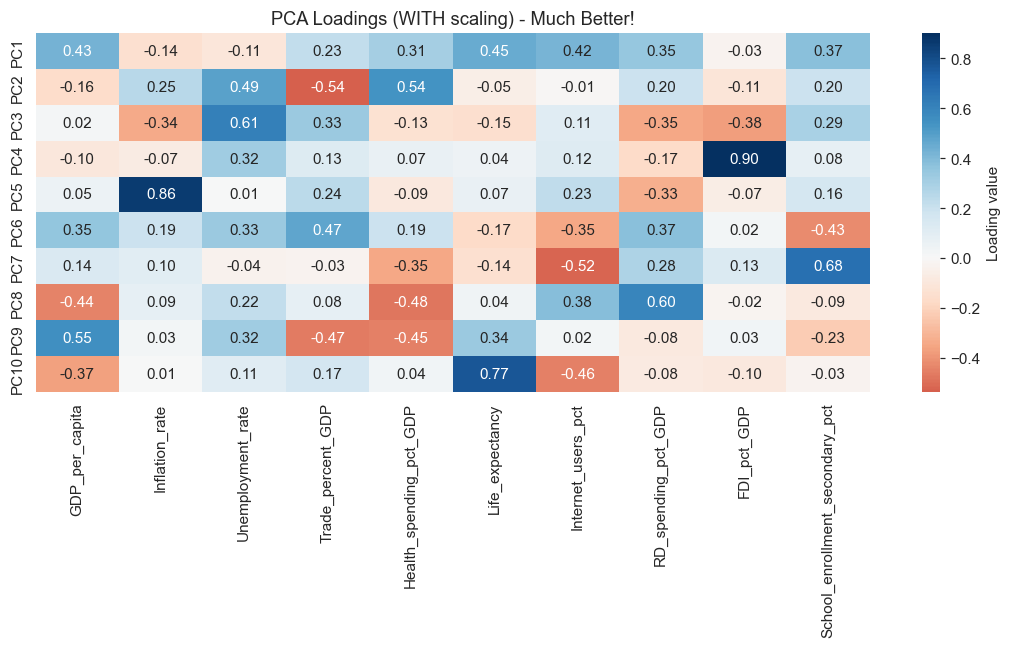

In [34]:
# Visualize loadings for scaled PCA
visualize_pca_loadings(scaled_pca, scaled_wb, 'PCA Loadings (WITH scaling) - Much Better!')
plt.show()

**Much better!** Now we see meaningful patterns:

**PC1 (~65-75% of variance):** "Development level"
- High positive loadings: Life_expectancy (0.45), GDP_per_capita (0.43), Internet_users (0.42)
- Interpretation: Distinguishes developed from developing countries

**PC2 (~10-15% of variance):** "Domestic welfare vs trade openness"
- High positive loadings: Health_spending (0.54), Unemployment (0.49)
- High negative loadings: Trade_pct_GDP (-0.54)
- Interpretation: Contrasts countries with high domestic spending/unemployment against trade-oriented economies

**Key insight:** Scaling revealed the true economic structure hidden in the data!

### Visualizing countries in PC space

Now let's see where countries are positioned in the new PC coordinate system. Countries with similar economic profiles should cluster together.

In [ ]:
# Apply PCA: fit and transform in one step (same as we did for the 2-features case)
scaled_wb_pca = scaled_pca.fit_transform(scaled_wb)

# Create scores DataFrame (countries in PC space)
scores = pd.DataFrame(
    scaled_wb_pca, 
    index=df['Country'], 
    columns=[f'PC{i+1}' for i in range(scaled_wb_pca.shape[1])]
)

# Create loadings DataFrame (feature contributions to PCs)
loadings = pd.DataFrame(
    scaled_pca.components_.T, 
    index=scaled_wb.columns, 
    columns=[f'PC{i+1}' for i in range(scaled_pca.components_.shape[0])]
)

print('Scores shape:', scores.shape)
print('Loadings shape:', loadings.shape)

In [ ]:
# Scatter plot of countries in PC1-PC2 space
plt.figure(figsize=(10, 8))
plt.scatter(scores['PC1'], scores['PC2'], alpha=0.5, s=80, color='steelblue', edgecolors='white', linewidth=0.5)

# Label a diverse selection of countries to show clustering patterns
to_label = [c for c in [
    # Developed economies
    'USA', 'DEU', 'NOR', 'SWE', 'CHE', 'JPN', 'AUS', 'CAN', 'GBR', 'FRA',
    # Emerging markets
    'CHN', 'IND', 'BRA', 'RUS', 'MEX', 'TUR', 'IDN', 'ZAF',
    # Developing countries
    'PAK', 'NGA', 'BGD', 'ETH', 'KEN', 'VNM',
    # Special cases
    'ARG', 'SGP', 'HUN', 'IRL', 'LUX'
] if c in scores.index]

for c in to_label:
    plt.annotate(c, (scores.loc[c, 'PC1'], scores.loc[c, 'PC2']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold', alpha=0.8)

plt.xlabel(f'PC1: Development Level ({scaled_pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2: Domestic Welfare vs Trade Openness ({scaled_pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.title('Countries in Principal Component Space\n(Similar countries cluster together)', fontsize=14, fontweight='bold')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Observations from the country scatter:**
- **Horizontal axis (PC1 - Development level):** 
  - Right side: Developed economies (USA, DEU, NOR, SWE, CHE, JPN, AUS, GBR, FRA, CAN)
  - Left side: Developing countries (PAK, NGA, BGD, ETH, KEN)
  - Middle: Emerging markets (CHN, IND, BRA, MEX, TUR, IDN, ZAF)
- **Vertical axis (PC2 - Domestic welfare vs trade openness):**
  - Positive: Countries with high domestic spending/unemployment (e.g., ZAF, some European countries)
  - Negative: Trade-oriented economies (SGP, IRL, LUX)
- **Clusters:** Countries with similar economic profiles naturally group together:
  - Nordic countries (NOR, SWE) cluster near other developed economies
  - BRICS countries (CHN, IND, BRA, RUS, ZAF) show varied positions reflecting their diverse profiles
  - Sub-Saharan African countries (NGA, ETH, KEN) cluster on the left (lower development)
  - Small open economies (SGP, IRL, LUX) show negative PC2 (high trade orientation)

**Achievement:** We've compressed 9 dimensions into 2, making invisible patterns visible!

### Biplot: Combining Countries and Indicators

A **biplot** overlays both countries (points) and indicators (arrows) in the same PC space. This powerful visualization shows:
- Where countries are positioned
- Which indicators drive those positions
- How indicators relate to each other

**How to read it:**
- **Arrow direction:** Shows which way that indicator "pulls" countries
- **Arrow length:** Longer = more influence on the visible PCs
- **Arrow angles:** Small angle = indicators are correlated; opposite directions = negatively correlated

In [ ]:
def create_biplot(scores_df, loadings_df, explained_variance_ratio, pc1=0, pc2=1, scale_factor=4):
    """Create a biplot showing both countries (scores) and indicators (loadings)"""
    fig, ax = plt.subplots(figsize=(14, 10))
    pc1_name = f'PC{pc1+1}'
    pc2_name = f'PC{pc2+1}'

    # Plot country scores
    ax.scatter(scores_df[pc1_name], scores_df[pc2_name], alpha=0.55, s=70, 
              color='steelblue', edgecolors='white', linewidth=0.5, label='Countries')

    # Label selected countries
    to_label = [c for c in ['USA', 'CHN', 'IND', 'NOR', 'PAK', 'ARG', 'SGP', 'HUN', 'NGA', 'DEU'] 
               if c in scores_df.index]
    for c in to_label:
        ax.annotate(c, (scores_df.loc[c, pc1_name], scores_df.loc[c, pc2_name]), 
                   xytext=(5, 5), textcoords='offset points', fontsize=10)

    # Plot indicator vectors (arrows)
    for indicator in loadings_df.index:
        x = loadings_df.loc[indicator, pc1_name] * scale_factor
        y = loadings_df.loc[indicator, pc2_name] * scale_factor
        ax.arrow(0, 0, x, y, color='darkred', alpha=0.7, head_width=0.12, head_length=0.12, 
                linewidth=2.5, length_includes_head=True)
        # Clean up indicator names for display
        label = indicator.replace('_', ' ')
        ax.text(x * 1.15, y * 1.15, label, color='darkred', fontsize=10, 
               ha='center', va='center', fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='darkred'))

    ax.set_xlabel(f'{pc1_name} ({explained_variance_ratio[pc1]*100:.1f}% variance)', 
                 fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{pc2_name} ({explained_variance_ratio[pc2]*100:.1f}% variance)', 
                 fontsize=12, fontweight='bold')
    ax.set_title('Biplot: Countries (blue) + Economic Indicators (red arrows)', 
                fontsize=14, fontweight='bold')
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.grid(alpha=0.3)
    ax.legend(loc='upper left')
    plt.tight_layout()
    return fig, ax

create_biplot(scores, loadings, scaled_pca.explained_variance_ratio_, pc1=0, pc2=1, scale_factor=4)
plt.show()

**Interpreting the biplot:**
- **GDP_per_capita and Life_expectancy** point right → developed countries (USA, DEU, NOR) are on that side
- **Population_growth** points left → developing countries (IND, PAK, NGA) have higher population growth
- **Trade_pct_GDP** points up → captures Singapore's trade-oriented economy (SGP high on PC2)
- **Correlated indicators** point in similar directions (e.g., GDP and Life expectancy)

This single plot tells the economic story of how countries differ!

### Robustness Check: Do outliers change PCA?

Some countries (Argentina, Singapore, Hungary) have unusual economic profiles. Do these outliers distort our PCA results? Let's check by refitting PCA without them.

In [ ]:
# Remove outliers and refit PCA
outliers = [c for c in ['ARG', 'SGP', 'HUN'] if c in scores.index]
print(f'Removing outliers: {outliers}')

mask = ~df['Country'].isin(outliers)
wb_features_wo = wb_features.loc[mask]
scaled_wb_wo = StandardScaler().fit_transform(wb_features_wo)
pca_wo = PCA().fit(scaled_wb_wo)

# Compare results
print(f'\n--- Comparison: All countries vs. Without outliers ---')
print(f'PC1 variance explained (all):        {scaled_pca.explained_variance_ratio_[0]:.1%}')
print(f'PC1 variance explained (no outliers): {pca_wo.explained_variance_ratio_[0]:.1%}')

# Compare PC1 loadings
common = wb_features_wo.columns
loadings_wo = pd.Series(pca_wo.components_[0], index=common)
corr = np.corrcoef(loadings.loc[common, 'PC1'].values, loadings_wo.values)[0, 1]
print(f'\nCorrelation between PC1 loadings: {corr:.3f}')
print('(Values close to ±1 mean loadings barely changed)')

print('\n✓ Result: Outliers have minimal impact on PCA structure')

---

## Summary: PCA

### What we learned

**1. Motivation: Dimensionality Reduction**
- Goal: Summarize many features with fewer dimensions while preserving information
- Method: Project data onto directions that maximize variance
- Why variance? It measures how spread out (informative) the projected data is

**2. PCA Mechanics**
- PC1: Direction of maximum variance
- PC2: Maximum remaining variance, perpendicular to PC1
- Continues sequentially for all dimensions

**3. Key Characteristics**

| Property | Explanation | Why It Matters |
|----------|-------------|----------------|
| **Loadings** | Weights showing how features combine into PCs | Interprets what each PC represents |
| **Orthogonality** | PCs are perpendicular (uncorrelated) | Each PC captures independent information |
| **Explained Variance** | Proportion of total variance each PC captures | Guides how many PCs to keep |
| **Reconstruction Error** | Information lost when using fewer PCs | Quantifies dimension reduction trade-off |

**4. Connection to OLS**
- OLS: Minimizes vertical distances (predicts Y from X)
- PCA: Minimizes perpendicular distances (symmetric treatment)
- Use OLS for prediction, PCA for understanding structure

**5. Critical Requirement: Standardization**
- **Problem:** Features with larger scales dominate PCA
- **Solution:** Standardize (mean=0, std=1) before PCA
- **Always remember:** Scale first, then PCA!

**6. Practical Application**
- Compressed 9 economic indicators → 2 PCs
- PC1 captured "development level" (~65-75% variance)
- PC2 captured "economic openness" (~10-15% variance)
- Biplot revealed economic structure across countries

### When to use PCA

**✅ PCA works well when:**
- Features are correlated (redundant information to compress)
- Need visualization (reduce to 2-3D)
- Want to discover underlying patterns
- Building models and want uncorrelated features

**❌ Be cautious when:**
- Features have vastly different scales (standardize first!)
- Features are already uncorrelated (little to gain)
- Individual feature interpretation is critical (PCs are combinations)
- Need non-linear patterns (PCA is linear)

**The big picture:** PCA is one powerful tool for fighting the curse of dimensionality. By finding the directions of maximum variance, it lets us work in lower dimensions while preserving the information that matters most.